In [46]:
%load_ext autoreload
%autoreload 2
from test_f16 import *
from f16 import *
# from trim import *
import matplotlib.pyplot as plt
import control
import scipy.linalg


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Test simulate with given control function and initial state

In [47]:
def simulate_1(x0: State, f_control, p: Parameters, t0: float, tf: float, dt: float):
    """
    Simulate the aircraft for a given control function and initial state.

    Parameters:
    x0: initial state (see State)
    f_control: A function of the form f(t, x), which returns the control u
    p: Aircraft parameters
    t0: initial time
    tf: fintal time
    dt: The discrete sampling time of the controller.
    """
    xs = ca.MX.sym('x', 16)
    x = State.from_casadi(xs)
    us = ca.MX.sym('u', 4)
    u = Control.from_casadi(us)
    dae = {'x': xs, 'p': us, 'ode': dynamics(x, u, p).to_casadi()}
    F = ca.integrator('F', 'idas', dae, {'t0': 0, 'tf': dt, 'jit': True}) # 'tf' = dt?
    x = np.array(x0.to_casadi()).reshape(-1)
    u0 = f_control(t0, x0)
    # display(u0)
    u = np.array(u0.to_casadi()).reshape(-1)
    data = {
        't': [0],
        'x': [x]
    }
    t_vect = np.arange(t0, tf, dt)
    for t in t_vect:
        u0 = f_control(t, x) # Default control input is set to zero
        # display(u0)
        u = np.array(u0.to_casadi()).reshape(-1)
        x = np.array(F(x0=x, p=u)['xf']).reshape(-1)
        data['t'].append(t)
        data['x'].append(x)
    for k in data.keys():
        data[k] = np.array(data[k])
    return data

In [48]:
def test_simulate_1():
    f_control = lambda t, x: f16.Control()
    data1 = simulate_1(x0=f16.State(VT=502), f_control= f_control,
        p=f16.Parameters(), t0=0, tf=10, dt=0.01)
    return data1
data1=test_simulate_1()

In [49]:
def plot_2D_display(title = None, x_value = [0], y_value = [0], x_label= None,y_label=None):
    plt.figure()
    plt.plot(x_value,y_value)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()

def plot_sim_data(data, plot_trajectory=False):
    ''' 
    Accept dictionary type "data" from simulate function and plot each data type separately
    '''
    t = data['t']
    x1 = data['x']
    x = f16.State(VT=x1[:,0],alpha=x1[:,1],beta=x1[:,2],phi=x1[:,3],
                  theta=x1[:,4],psi=x1[:,5],P=x1[:,6],Q=x1[:,7],R=x1[:,8],
                  p_N=x1[:,9], p_E=x1[:,10], alt = x1[:,11],power=x1[:,12],
                  ail_deg=x1[:,13],elv_deg=x1[:,14],rdr_deg=x1[:,15])
    plot_2D_display(title='VT vs t', x_value=t, y_value=x.VT)
    plot_2D_display(title='AoA, Alpha vs t', x_value=t,y_value=np.rad2deg(data['x'][:, f16.State().name_to_index('alpha')]),
                    x_label='time, sec',y_label=r'$\alpha$, deg')
    plot_2D_display(title='Altitude vs t', x_value=t,y_value= x.alt)

    if plot_trajectory == True:
        plt.figure()
        plt.plot(x.p_E,x.p_N)
        plt.xlabel('Position East, ft')
        plt.ylabel('Position North, ft')
        plt.title('Coordinate Trajectory')
        plt.grid()
        plt.axis('equal')

# plot_sim_data(data1, plot_trajectory=True)

## Pitch-Rate CAS Design [Example 4.5-1]
pg 310

In [50]:
p = f16.Parameters()
x0, u0 = f16.trim(x=f16.State(VT=502), p=p, phi_dot=0.0,theta_dot=0,psi_dot=0.0, gam=0)
def f_control(t,x): ## REVISE how to convert state into control u
    ''' 
    Control function from Table 3.6-3 pg 197
    function returns control u
    '''
    return f16.Control(thtl=u0.thtl,
                       ail_cmd_deg=u0.ail_cmd_deg,
                        elv_cmd_deg=u0.elv_cmd_deg+ 1*np.sin(2*np.pi*2*t),
                        rdr_cmd_deg=u0.rdr_cmd_deg)
f_control(0, x0) #test nominal trim condition

Control(thtl=DM(0.138556), ail_cmd_deg=DM(0), elv_cmd_deg=DM(-0.75878), rdr_cmd_deg=DM(0))

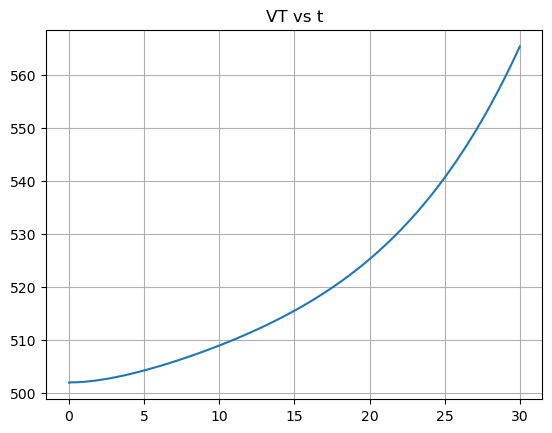

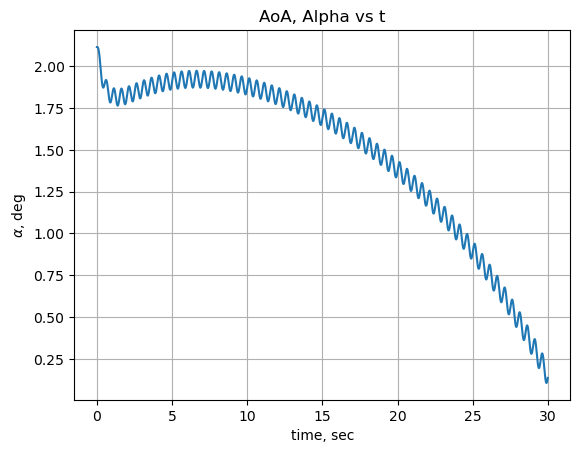

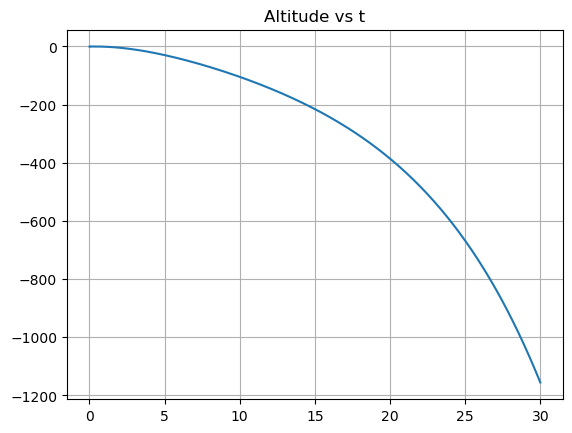

In [51]:
data2 = simulate_1(x0, f_control,
    p, t0=0, tf=30, dt=0.01)
plot_sim_data(data2,plot_trajectory=False)

In [52]:
def select(n, i):
    D = np.zeros((1, n))
    D[0, i] = 1
    return control.ss([], [], [], D)

ss = f16.linearize(x0, u0, p)
s = control.tf([1, 0], [0, 1])
G = -(180/np.pi)*ss.sub_system(x=['alpha', 'Q', 'elv_deg'],
                  u=['elv_cmd_deg'], y=['alpha', 'Q']).to_control()
sys3 = control.feedback(G, 0.2*10/(s+10)*select(2, 0))
sys3

<LinearICSystem:sys[105]:['u[0]']->['y[0]', 'y[1]']>

## Automatic Landing System (pg. 338)

In [53]:
## Trimmed condition, gear down + Landing flap
# x2 = f16.State(VT=250)
p2 = f16.Parameters(xcg=0.25)
x02, u02 = f16.trim(x=f16.State(VT=250,alt=750*0.3048), p=p, phi_dot=0,theta_dot=0,psi_dot=0.0, gam=-2.5 * np.pi/180)
display(x02,u02)

def f_control(t,x): ## REVISE --> function accepts t,x and return u
    ''' 
    Control function matches Table 3.6-3 pg 197
    function returns control u
    '''
    # Look into inputs functions 

    # 
    return f16.Control(thtl=u0.thtl,ail_cmd_deg=u0.ail_cmd_deg,
                        elv_cmd_deg=u0.elv_cmd_deg+ 1*np.sin(2*np.pi*2*t),
                        rdr_cmd_deg=u0.rdr_cmd_deg)
# f_control(0, x02) #input t and u

State(VT=250, alpha=DM(0.222596), beta=DM(0), phi=DM(0), theta=DM(0.180898), psi=0, P=DM(0), Q=DM(0), R=DM(0), p_N=0, p_E=0, alt=228.60000000000002, power=DM(6.96715), ail_deg=DM(0), elv_deg=DM(0.288567), rdr_deg=DM(0))

Control(thtl=DM(0.107286), ail_cmd_deg=DM(0), elv_cmd_deg=DM(0.288567), rdr_cmd_deg=DM(0))

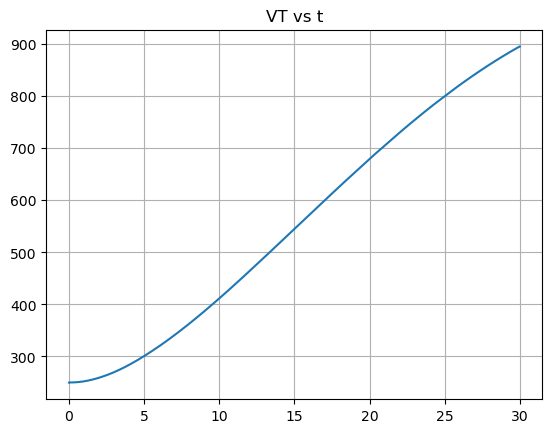

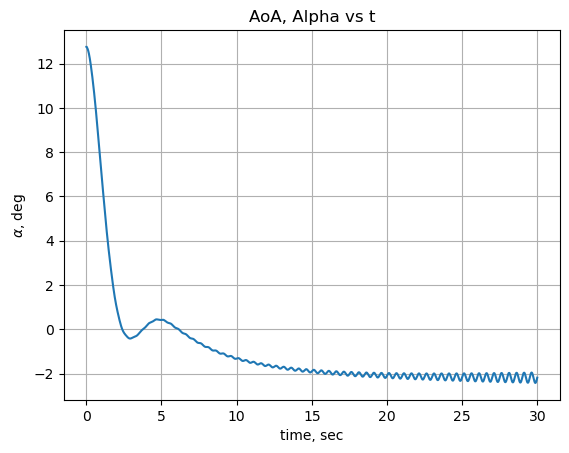

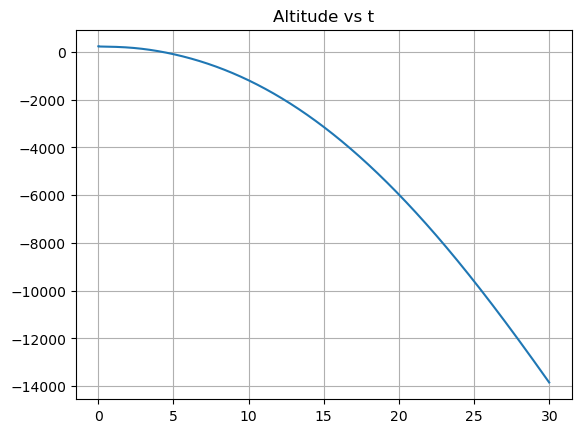

In [54]:
data2 = simulate(x0=x02, f_control=f_control,
    p=p2, t0=0, tf=30, dt=0.01)
plot_sim_data(data2,plot_trajectory=False)

In [55]:
# Simple Landing Trajectory
''' 
Start at 750 ft descend to 0
'''
y_ref = np.linspace(750*0.3048,0,1000) #Altitude reference vector
t = np.linspace(0,60,1000) #Time vector

# plt.figure()
# plt.plot(t,y_ref)
# plt.xlabel('Time ,s')
# plt.ylabel('Altitude, m')


In [56]:
## Simulate Landing Trajectory
def sim_landing(ref):
    p2 = f16.Parameters(xcg=0.25)
    x02, u02 = f16.trim(x=f16.State(VT=250, alt=750), p=p, phi_dot=0,theta_dot=0,psi_dot=0.0, gam=-2.5 * np.pi/180)
    display(x02,u02)

    def f_control(t,x):
        ''' 
        Control function matches Table 3.6-3 pg 197
        function returns control u
        '''
        
        return f16.Control(thtl=u0.thtl,ail_cmd_deg=u0.ail_cmd_deg,
                        elv_cmd_deg=u0.elv_cmd_deg+ 1*np.sin(2*np.pi*2*t),
                        rdr_cmd_deg=u0.rdr_cmd_deg)
    
    def sim_f16():
        f_control = f_control(t,x0)
        data = simulate_1(x0=f16.State(VT=502), f_control= f_control,
                          p=f16.Parameters(), t0=0, tf=10, dt=0.01)
        return data
        




In [57]:
''' 
For Automatic landing, variables required for sub systems are
ap : VT , alpha, theta, Q, alt, d
bp : thtl_input , elevator_inpput

** Note ss sub_system alpha, theta, Q are in radians
'''
ss = f16.linearize(x02, u02, p2)
# display(ss)
s = control.tf([1, 0], [0, 1])
G1 = ss.sub_system(x=['VT', 'alpha', 'theta', 'Q', 'alt', 'power', 'elv_deg'],
                  u=['thtl','elv_cmd_deg'], y=['VT', 'alpha', 'theta', 'Q', 'alt']).to_control()
# sys3 = control.feedback(G2, 0.2*10/(s+10)*select(2, 0))
# sys3
G1


<LinearIOSystem:sys[108]:['u[0]', 'u[1]']->['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]']>

In [58]:
# control.ss2tf(G1)

In [59]:
## Considering Vc Loop
H = 0.2 / (s+0.2)

In [60]:
## Simulate Velocity, Vc input, Control -- accepts Vc input
s = control.tf([1, 0], [0, 1])
G2 = -(180/np.pi)*ss.sub_system(x=['alpha', 'Q', 'elv_deg'],
                  u=['elv_cmd_deg'], y=['alpha', 'Q']).to_control() #Aircraft ss
sys3= 0.2/(s+0.2)*select(2,0)*G2 * control.feedback(1,sign=-1)
sys3

<LinearICSystem:sys[132]:['u[0]']->['y[0]']>

In [61]:
# control.rlocus(H,kvect=np.linspace(0,1,10))

In [62]:
G2*H

<LinearICSystem:sys[135]:['u[0]']->['y[0]', 'y[1]']>

## Longitudinal Control for Automatic Landing
Pg 340-341


In [63]:
def get_jacobian(x0,u0):
    ''' Accepts x0 states and u0 control at trimmed condition and calculate A and B Jacobian matrix'''
    x_sym = ca.MX.sym('x', 16)
    u_sym = ca.MX.sym('u', 4)
    x = f16.State.from_casadi(x_sym)
    u = f16.Control.from_casadi(u_sym)
    p = f16.Parameters()
    dx = f16.dynamics(x, u, p)
    A = ca.jacobian(dx.to_casadi(), x_sym)
    B = ca.jacobian(dx.to_casadi(), u_sym)
    f_A = ca.Function('A', [x_sym, u_sym], [A])
    f_B = ca.Function('B', [x_sym, u_sym], [B])
    ap=f_A(f16.State.to_casadi(x0), f16.Control.to_casadi(u0))
    bp=f_B(f16.State.to_casadi(x0), f16.Control.to_casadi(u0))
    return ap,bp

In [64]:
ap, bp = get_jacobian(x02,u02)

In [65]:
bp

DM(sparse: 16-by-4, 4 nnz
 (12, 0) -> 64.94
 (13, 1) -> 20.202
 (14, 2) -> 20.202
 (15, 3) -> 20.202)

In [66]:
cp = ca.DM([[0,0,57.29578,0,0,0],[0,0,0,57.29578,0,0]])
dp = [0,0]

## Transport Aircraft Model
Pg 182 for dynamic equations

In [67]:
from transport import *

x = [250, 0, 0, 0, 750*0.3048, 0]   # 
u = [0, 0, 0.25, 1]                 # Landing configuration

In [68]:
# x_sym = ca.SX.sym('x',6,1)
# u_sym = ca.SX.sym('u',4,1)
# x_dot = longitudinal(x_sym,u_sym)
# A = ca.jacobian(x_dot,x_sym)
# A

In [69]:
def trim_cost(x,u):
    x_dot = longitudinal(x,u)
    return x_dot[0]**2 + x_dot[1]**2 + x_dot[2]**2 + x_dot[3]**2 +x_dot[4]**2

x0=[250,0,0,0,0,0]
u0 = [0,0,0,0]
s = ca.MX.sym('s', 6)
# Design vector s= [thrl, elev, AoA]
# input alt , v_horizontal





In [70]:
res = trim(250,750,0,np.deg2rad(-2.5),land=1, gam_r=np.deg2rad(-3))
res


{'x0': array([ 2.50000000e+02,  3.82324011e-03, -3.98099912e-02,  0.00000000e+00,
         7.50000000e+02,  0.00000000e+00]),
 'u0': array([  0.30943376, -15.21842297,   0.25      ,   1.        ,
         -0.05235988]),
 's': array([ 3.09433756e-01, -1.52184230e+01,  3.82324011e-03])}

In [71]:
np.rad2deg(res['x0'][1])

0.21905552219357757

In [72]:
x_dot_check = longitudinal(res['x0'],res['u0'])
x_dot_check

SX([2.25785e-10, -1.96646e-08, 0, -1.97446e-09, -10.9048, 2.18163])

In [73]:
sys = linearize(res)
sys

<LinearIOSystem:sys[137]:['u[0]', 'u[1]', 'u[2]', 'u[3]', 'u[4]']->['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]']>

In [74]:
np.set_printoptions(precision=2,linewidth=100)
np.array(sys.A)

array([[-3.86e-02,  1.90e+01, -3.21e+01,  0.00e+00,  1.32e-04,  0.00e+00],
       [-1.03e-03, -6.33e-01,  5.61e-03,  1.00e+00,  3.76e-06,  0.00e+00],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00,  0.00e+00,  0.00e+00],
       [ 7.86e-05, -7.59e-01, -7.93e-04, -5.18e-01, -3.08e-07,  0.00e+00],
       [-4.36e-02, -2.50e+02,  2.50e+02,  0.00e+00,  0.00e+00,  0.00e+00],
       [ 8.73e-03, -2.50e+02,  2.50e+02,  0.00e+00,  0.00e+00,  0.00e+00]])